# DFT-NN

The idea behind this notebook is the use of a nearest neighbour regressor to predict the error of different DFT methods.

In [5]:
%matplotlib widget
%matplotlib notebook

In [6]:
import os
import tqdm
import numpy as np 
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import array_to_latex as a2l
import matplotlib as mpl
from functools import reduce, partial 

from utils.utils import flatten, save

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

from sklearn.datasets import make_blobs

# Preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

dataset_dir = "Dataset_24_08_21"#"Dataset_12-07-21"

def set_numpy_decimal_places(places, width=0):
    set_np = '{0:' + str(width) + '.' + str(places) + 'f}'
    np.set_printoptions(formatter={'float': lambda x: set_np.format(x)})
set_numpy_decimal_places(3)


# How to convert numpy arrays to latex:
#a2l.to_ltx(sort_mat(X), frmt = '{:6.1f}', arraytype = 'bmatrix')

In [7]:
darkmode = {"lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"}

lightmode = {"lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"}

mpl.rcParams.update(lightmode)

In [8]:
df = pd.read_csv("30Years/IndValues.csv")
df

,RefNames,DatasetRefNames,RefValues,B3LYP-D2,B3LYP-D3(BJ),B3LYP-D3(CSO),B3LYP-D3M(BJ),B3LYP-D3(0),B3LYP,B3LYP-NL,...,wB97,wB97M-rV,wB97M-V,wB97X-D3,wB97X-D,wB97X,wB97X-rV,wB97X-V,wM05-D,wM06-D3
0,A21x12_1,A21x12,-4.663,-5.529378,-5.152577,-4.975710,-5.270430,-5.132482,-4.166796,-5.525954,...,-5.304190,-4.479258,-4.500283,-4.942960,-4.955093,-5.378982,-4.662586,-4.683821,-4.522758,-4.910208
1,A21x12_2,A21x12,-6.529,-7.074401,-6.905123,-6.774258,-6.978272,-6.967121,-6.089573,-7.099935,...,-7.266147,-6.488420,-6.498405,-6.785856,-6.757608,-7.241035,-6.578600,-6.588762,-6.477699,-6.797096
2,A21x12_3,A21x12,-5.719,-6.099155,-5.980699,-5.893658,-6.018894,-6.010324,-5.335952,-6.064589,...,-6.288460,-5.739802,-5.742029,-5.883638,-5.819156,-6.274295,-5.805209,-5.807605,-5.732516,-5.903793
3,A21x12_4,A21x12,-4.429,-4.722861,-4.586489,-4.536677,-4.601200,-4.650935,-4.098536,-4.611349,...,-4.746188,-4.458708,-4.456385,-4.515507,-4.448131,-4.788279,-4.527368,-4.525246,-4.419604,-4.459385
4,A21x12_5,A21x12,-3.301,-3.406059,-3.373259,-3.351031,-3.374051,-3.426698,-3.018681,-3.372817,...,-3.399437,-3.322438,-3.318044,-3.362675,-3.297431,-3.498377,-3.386573,-3.382410,-3.255561,-3.189787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4981,C20C24_4,C20C24,46.270,-10.742103,-2.690180,-2.909344,1.592023,-14.761199,-19.744855,7.715920,...,38.618205,41.481005,42.198973,32.377996,27.277606,31.352199,45.992978,46.708731,30.952181,25.069114
4982,C20C24_5,C20C24,31.200,48.833390,57.257080,58.336598,56.345813,59.926243,66.314877,43.536631,...,10.830143,29.063456,28.432062,26.126924,25.165187,25.336189,16.173528,15.544118,44.114374,42.593363
4983,C20C24_6,C20C24,-5.320,25.137875,27.871618,28.890041,25.828563,32.859803,40.328423,13.770171,...,-7.718670,-0.990761,-1.743958,2.309006,1.242642,3.448072,-12.040618,-12.790367,15.142030,20.005021
4984,C20C24_7,C20C24,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
methods = list(df)[3:]

In [10]:
for col in methods:
    df[col+"_diff"] = df["RefValues"] - df[col]


/tmp/ipykernel_27922/4221855433.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col+"_diff"] = df["RefValues"] - df[col]


In [11]:
methods_diff = [method + '_diff' for method in methods]

corrs = np.corrcoef(df[methods_diff].to_numpy().T)

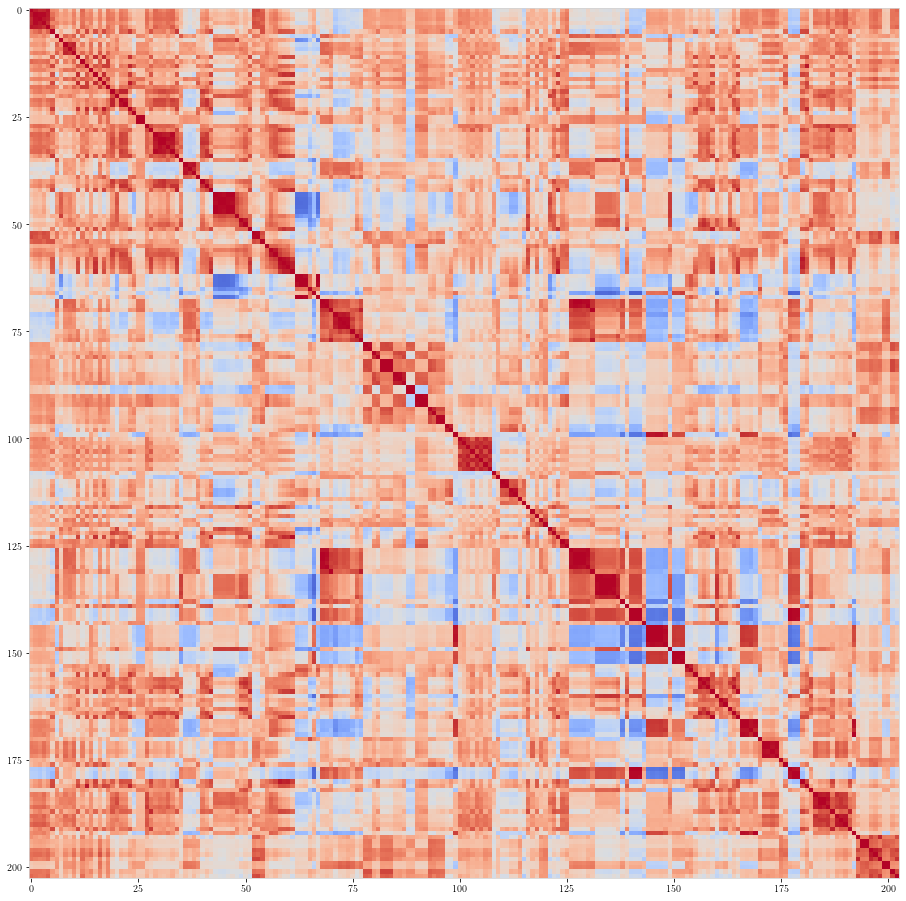

In [67]:
fig = plt.figure(figsize=(16,16))
plt.imshow(corrs,vmin=-1,vmax=1,cmap="coolwarm")
plt.show()

In [30]:
np.sort(df["B3LYP-D2"])[:10]

array([-331053.205, -288768.616, -249840.329, -214164.223, -181602.734,
       -152105.049, -125564.598, -101844.056, -80936.343, -62610.285])

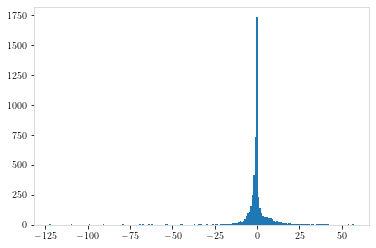

In [77]:
method = "PBE_diff"

plt.hist(df[method], bins=200)
plt.show()

In [80]:
df

,RefNames,DatasetRefNames,RefValues,B3LYP-D2,B3LYP-D3(BJ),B3LYP-D3(CSO),B3LYP-D3M(BJ),B3LYP-D3(0),B3LYP,B3LYP-NL,...,wB97_diff,wB97M-rV_diff,wB97M-V_diff,wB97X-D3_diff,wB97X-D_diff,wB97X_diff,wB97X-rV_diff,wB97X-V_diff,wM05-D_diff,wM06-D3_diff
0,A21x12_1,A21x12,-4.663,-5.529378,-5.152577,-4.975710,-5.270430,-5.132482,-4.166796,-5.525954,...,0.641190,-0.183742,-0.162717,0.279960,0.292093,0.715982,-0.000414,0.020821,-0.140242,0.247208
1,A21x12_2,A21x12,-6.529,-7.074401,-6.905123,-6.774258,-6.978272,-6.967121,-6.089573,-7.099935,...,0.737147,-0.040580,-0.030595,0.256856,0.228608,0.712035,0.049600,0.059762,-0.051301,0.268096
2,A21x12_3,A21x12,-5.719,-6.099155,-5.980699,-5.893658,-6.018894,-6.010324,-5.335952,-6.064589,...,0.569460,0.020802,0.023029,0.164638,0.100156,0.555295,0.086209,0.088605,0.013516,0.184793
3,A21x12_4,A21x12,-4.429,-4.722861,-4.586489,-4.536677,-4.601200,-4.650935,-4.098536,-4.611349,...,0.317188,0.029708,0.027385,0.086507,0.019131,0.359279,0.098368,0.096246,-0.009396,0.030385
4,A21x12_5,A21x12,-3.301,-3.406059,-3.373259,-3.351031,-3.374051,-3.426698,-3.018681,-3.372817,...,0.098437,0.021438,0.017044,0.061675,-0.003569,0.197377,0.085573,0.081410,-0.045439,-0.111213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4981,C20C24_4,C20C24,46.270,-10.742103,-2.690180,-2.909344,1.592023,-14.761199,-19.744855,7.715920,...,7.651795,4.788995,4.071027,13.892004,18.992394,14.917801,0.277022,-0.438731,15.317819,21.200886
4982,C20C24_5,C20C24,31.200,48.833390,57.257080,58.336598,56.345813,59.926243,66.314877,43.536631,...,20.369857,2.136544,2.767938,5.073076,6.034813,5.863811,15.026472,15.655882,-12.914374,-11.393363
4983,C20C24_6,C20C24,-5.320,25.137875,27.871618,28.890041,25.828563,32.859803,40.328423,13.770171,...,2.398670,-4.329239,-3.576042,-7.629006,-6.562642,-8.768072,6.720618,7.470367,-20.462030,-25.325021
4984,C20C24_7,C20C24,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
names = {}

with open("30Years/DatasetEval.csv", "r") as f:
    for line in f:
        names[line.split(",")[0]] = line.split(",")[2]


In [13]:
from ase.io import read

mols = []
for mol in tqdm.tqdm(df["RefNames"]):
    if mol.startswith("BDE") or mol.startswith("HAT707") or mol.startswith("TAE140"):
        continue
    mols.append(read("30Years/Geometries/"+names[mol]+".xyz"))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3023.93it/s]


In [14]:
import ase
import dscribe
import sklearn
from dscribe.descriptors import SOAP,CoulombMatrix, MBTR
from dscribe.kernels import REMatchKernel
from ase.build import molecule
from ase.io import read
from ase import Atoms
from sklearn.preprocessing import normalize
from dscribe.descriptors import SOAP

if not os.path.exists("Representations"):
    os.mkdir("Representations")

# QM9_setup 

species = ["H","He","Li","Be","B","C","O","N","F","Ne","Na","Mg","Al","Si","P","S","Cl","Ar","K","As","Se","Br","Kr"]
rcut = 6.0
nmax = 8
lmax = 6

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=False,
    rcut=rcut,
    nmax=nmax,
    lmax=lmax,
)

average_soap = SOAP(
    species=species,
    rcut=rcut,
    nmax=nmax,
    lmax=lmax,
    average="inner",
    sparse=False
)

# Setting up the CM descriptor
cm = CoulombMatrix(
    n_atoms_max=60
)

# Setting up the MBTR descriptor
mbtr = MBTR(
    species=species,
    k1={
        "geometry": {"function": "atomic_number"},
        "grid": {"min": 0, "max": 18, "n": 100, "sigma": 0.1},
    },
    k2={
        "geometry": {"function": "inverse_distance"},
        "grid": {"min": 0, "max": 1, "n": 100, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
    },
    k3={
        "geometry": {"function": "cosine"},
        "grid": {"min": -1, "max": 1, "n": 100, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
    },
    periodic=False,
    normalization="l2_each",
)

avsoap_mols = np.array([average_soap.create(mol) for mol in tqdm.tqdm(mols, position=0, leave=True)])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:04<00:00, 865.17it/s]


In [15]:
names = ["AvSOAP"]#, "MBTR", "CM"]

mol_reps = {name : normalize(mols) for name,mols in zip(names,[avsoap_mols])}#, mbtr_mols, cm_mols])}

In [12]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

dim_PCA = {}
n_components = 200

for i,item in enumerate(mol_reps.items()):
    pca = PCA(n_components=n_components)
    name, rep = item
    pca.fit(rep)
    dim_PCA[name] = pca
    
def find_nearest(array, value, return_idx=False):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if return_idx:
        return idx
    else:
        return array[idx]
    
fig, axs = plt.subplots(1,1,figsize=(16,5), sharex=True, sharey=True)

PCA_dims = {}
cutoff = 0.99

for i,item in enumerate(mol_reps.items()):
    name, rep = item
    ax = axs
    ax.plot(range(1,n_components+1),np.cumsum(dim_PCA[name].explained_variance_ratio_), color="k")
    ax.set_xlabel('number of components')
    
    if i == 0:
        ax.set_ylabel("Cumulative Explained Variance",fontsize=16)
    
    dims = find_nearest(np.cumsum(dim_PCA[name].explained_variance_ratio_), cutoff, return_idx=True)+1
    PCA_dims[name] = dims
    
    ax.axhline(cutoff, color="k", dashes=(1,5))
    ax.axvline(dims-1,color="k", dashes=(1,5))
    ax.set_title(name,fontsize=20)
    ax.set_xlabel("Number of Dimensions",fontsize=16)

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [13]:
cm_mols = np.array([cm.create(mol) for mol in tqdm.tqdm(mols,position=0, leave=True)])

100%|███████████████████████████████████████████████████████████████████████████████████████████| 4040/4040 [00:00<00:00, 4416.91it/s]


In [198]:
mbtr_mols = np.array([mbtr.create(mol) for mol in tqdm.tqdm(mols,position=0, leave=True)])

  7%|████                                                        | 273/4040 [00:03<00:44, 84.40it/s]/home/adam/anaconda3/envs/chemistry/lib/python3.8/site-packages/sparse/_umath.py:541: RuntimeWarning: invalid value encountered in true_divide
  fill_value_array = self.func(


ValueError: This operation requires consistent fill-values, but argument 1 had a fill value of nan, which is different from a fill_value of 0.0 in the first argument.

  7%|████                                                        | 273/4040 [00:17<00:44, 84.40it/s]

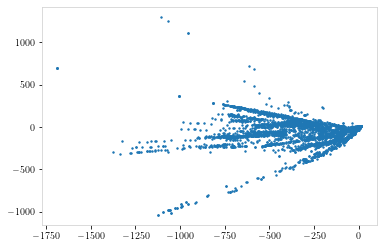

In [199]:
plt.scatter(*dim_PCA["AvSOAP"].transform(avsoap_mols)[:,:2].T, s=2)
plt.show()

In [200]:
plt.scatter(PCA().fit_transform(avsoap_mols).T, s=2)
plt.show()

KeyboardInterrupt: 

In [16]:
from sklearn.decomposition import KernelPCA, PCA

d3 = KernelPCA(n_components=3, kernel="rbf",gamma=1).fit_transform(mol_reps["AvSOAP"])

In [18]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection="3d")

ax.scatter(*d3.T,s=2)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …